In [1]:
import numpy as np
# generate SEM
import sys
sys.path.append("..")
import scipy.stats as scistats
from notears.notears.notears import linear
from notears.notears.notears import utils
import helper.helper as h
import helper.methods as m
from timeit import default_timer as timer
from importlib import reload  # Python 3.4+
reload(linear)
import matplotlib.pyplot as plt

In [2]:
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

In [42]:
utils.set_random_seed(1)

n, d, s0, graph_type, sem_type = 100, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {d} nodes and {s0} edges, {n} samples.")

B_true = utils.simulate_dag(d, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = utils.simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = utils.simulate_linear_sem(W_true, n, sem_type)

W_est, h_val = linear.notears_linear(X, lambda1=0.1, loss_type='l2-var', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)

SEM based on a graph on 5 nodes and 5 edges, 100 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5 -1.9]
 [-1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.1]
 [ 0.   0.  -0.9  0.   0. ]].

Estimated WAM:
[[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.3 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]].

{'fdr': 1.0, 'tpr': 0.0, 'fpr': 0.2, 'shd': 6, 'nnz': 1}


In [46]:
Ps = [10, 20, 50, 100]
print(list(Ps))
T = 1000
edges_per_var = 4

r_NT = [[[] for _ in range(6)] for _ in range(len(Ps))]
r_OMP = [[[] for _ in range(6)] for _ in range(len(Ps))]

[10, 20, 50, 100]


In [47]:
# numer of iterations
iters = 10
OMP_iters = 10

# number of different node sizes to try
for i, p in enumerate(Ps):
    
    print(f"{p}:", end = "\t")
    
    graph_type, sem_type = 'ER', 'gauss'
    s0 = int(min(edges_per_var * p, p * (p - 1) / 2))
    
    # number of iterations, more accurate results
    for j in range(iters):
        print(j, end = "\t")
    
        B_true = utils.simulate_dag(p, s0, graph_type)
        W_true = utils.simulate_parameter(B_true)
        X = utils.simulate_linear_sem(W_true, T, sem_type)
        
        ## NOTEARS
        notears_timer = timer()
        W_est, h_val = linear.notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False, w_threshold = 0.30)
        r_NT[i][0].append(timer() - notears_timer)
        
        # get accuracy
        acc = utils.count_accuracy(B_true, W_est != 0)
        
        # append results
        r_NT[i][1].append(acc['tpr'])
        r_NT[i][2].append(acc['fdr'])
        r_NT[i][3].append(acc['shd'])
        r_NT[i][4].append(h.MSE(W_est, X, is_sem = True))
        r_NT[i][5].append(acc['fpr'])

        # OMP
        for _ in range(OMP_iters):
            omp_timer = timer()
            W, r = m._K_OMP(X, X, F = [i * (p + 1) for i in range(p)], normalize = True, tol = 0.05)
            W[np.abs(W) <= 0.3] = 0
            r_OMP[i][0].append(timer() - omp_timer)

            acc = utils.count_accuracy(B_true, W != 0)

            r_OMP[i][1].append(acc['tpr'])
            r_OMP[i][2].append(acc['fdr'])
            r_OMP[i][3].append(acc['shd'])
            r_OMP[i][4].append(h.MSE(W, X, is_sem = True))
            r_OMP[i][5].append(acc['fpr'])
            
            B_true = utils.simulate_dag(p, s0, graph_type)
            W_true = utils.simulate_parameter(B_true)
            X = utils.simulate_linear_sem(W_true, T, sem_type)

    np.savetxt(f"../Week 23/benchmarks/4p edges gauss noise 1000 samples/r_OMP_{p}.txt", r_OMP[i])
    np.savetxt(f"../Week 23/benchmarks/4p edges gauss noise 1000 samples/r_NT_{p}.txt", r_NT[i])
    
    print()

10:	0	1	2	3	4	5	6	7	8	9	
20:	0	1	2	3	4	5	6	7	8	9	
50:	0	1	

..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h


2	3	4	5	6	7	8	9	
100:	0	1	2	3	4	5	6	7	8	9	


In [37]:
Ps = range(1, 100)
Ps_OMP, Ps_NT = [], []

OMP_means, OMP_ses = [], []
NT_means, NT_ses = [], []

# load data
for p in Ps:
    
    try:
        OMP_data = np.loadtxt(f"benchmarks/r_OMP_{p}.txt")
        Ps_OMP.append(p)
        OMP_means.append(np.mean(OMP_data[:5], axis = 1))
        OMP_ses.append(scistats.sem(OMP_data[:5], axis = 1))
    except OSError:
        continue
    
    try:
        NT_data = np.loadtxt(f"benchmarks/r_NT_{p}.txt")
        Ps_NT.append(p)
        NT_means.append(np.mean(NT_data[:5], axis = 1))
        NT_ses.append(scistats.sem(NT_data[:5], axis = 1))
    except:
        continue

OMP_means = np.array(OMP_means)
OMP_ses = np.array(OMP_ses)
NT_means = np.array(NT_means)
NT_ses = np.array(NT_ses)

print(len(Ps_NT))
print(np.shape(OMP_means))
print(np.shape(NT_means))

45
(90, 5)
(45, 5)


In [38]:
# Ps = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

p_index = 2
m_index = 2

print(f"Showing mean scores for p = {Ps[p_index]}, Metric = ", end = "")
if m_index == 0: print("Time.")
elif m_index == 1: print("TPR.")
elif m_index == 2: print("FDR.")
elif m_index == 3: print("SHD.")
elif m_index == 4: print("MSE.")
    
print(f"OMP:\t{np.round(OMP_means[p_index][m_index], 2)} +- {round(OMP_ses[p_index][m_index], 2)}.")
print(f"NOTEAR:\t{np.round(NT_means[p_index][m_index], 2)} +- {round(NT_ses[p_index][m_index], 2)}.")

Showing mean scores for p = 3, Metric = FDR.
OMP:	0.15 +- 0.01.
NOTEAR:	0.05 +- 0.01.


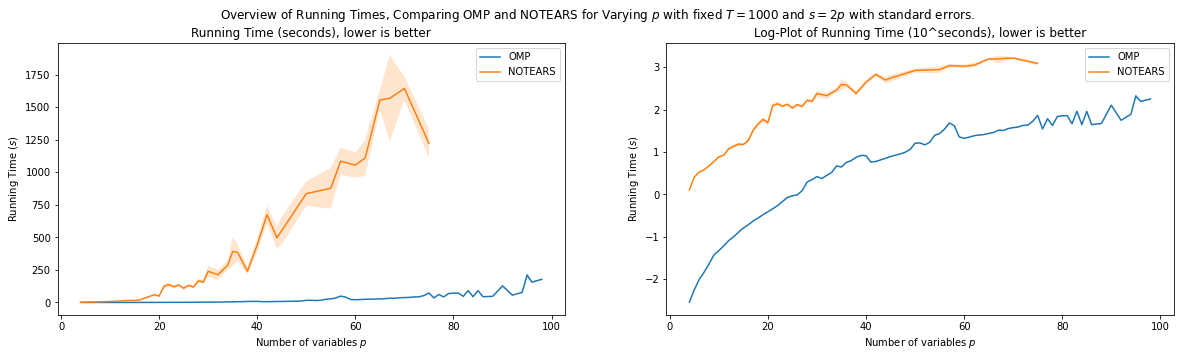

In [39]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle("Overview of Running Times, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = 2p$ with standard errors.")
titles = ['Running Time (seconds), lower is better', 'Log-Plot of Running Time (10^seconds), lower is better']

axs[0].plot(Ps_OMP, OMP_means[:, 0], label = "OMP")
axs[0].fill_between(Ps_OMP, OMP_means[:, 0] - OMP_ses[:, 0], OMP_means[:, 0] + OMP_ses[:, 0], alpha = 0.2)

axs[0].plot(Ps_NT, NT_means[:, 0], label = "NOTEARS")
axs[0].fill_between(Ps_NT, NT_means[:, 0] - NT_ses[:, 0], NT_means[:, 0] + NT_ses[:, 0], alpha = 0.2)
 
axs[1].plot(Ps_OMP, np.log10(OMP_means[:, 0]), label = "OMP")
axs[1].fill_between(Ps_OMP, np.log10(OMP_means[:, 0] - OMP_ses[:, 0]), np.log10(OMP_means[:, 0] + OMP_ses[:, 0]), alpha = 0.2)

axs[1].plot(Ps_NT, np.log10(NT_means[:, 0]), label = "NOTEARS")
axs[1].fill_between(Ps_NT, np.log10(NT_means[:, 0] - NT_ses[:, 0]), np.log10(NT_means[:, 0] + NT_ses[:, 0]), alpha = 0.2)

for i in range(2):
    axs[i].set_title(titles[i])
    axs[i].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='Running Time ($s$)')

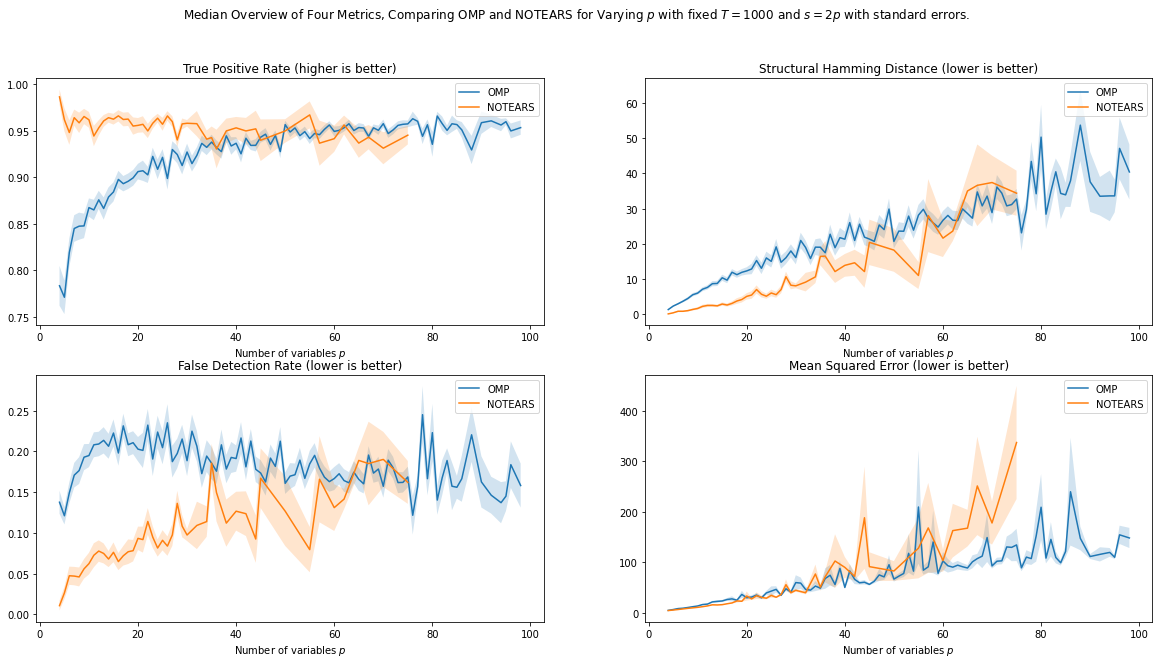

In [40]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Median Overview of Four Metrics, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = 2p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Detection Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'Mean Squared Error (lower is better)']

for i in range(0, 4):
    axs[i % 2, i // 2].plot(Ps_OMP, OMP_means[:, i + 1], label = "OMP")
    axs[i % 2, i // 2].fill_between(Ps_OMP, OMP_means[:, i + 1] - OMP_ses[:, i + 1], OMP_means[:, i + 1] + OMP_ses[:, i + 1], alpha = 0.2)

    axs[i % 2, i // 2].plot(Ps_NT, NT_means[:, i + 1], label = "NOTEARS")
    axs[i % 2, i // 2].fill_between(Ps_NT, NT_means[:, i + 1] - NT_ses[:, i + 1], NT_means[:, i + 1] + NT_ses[:, i + 1], alpha = 0.2)
    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')

C:\Users\s165048\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\s165048\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


ValueError: x and y must have same first dimension, but have shapes (99,) and (5,)

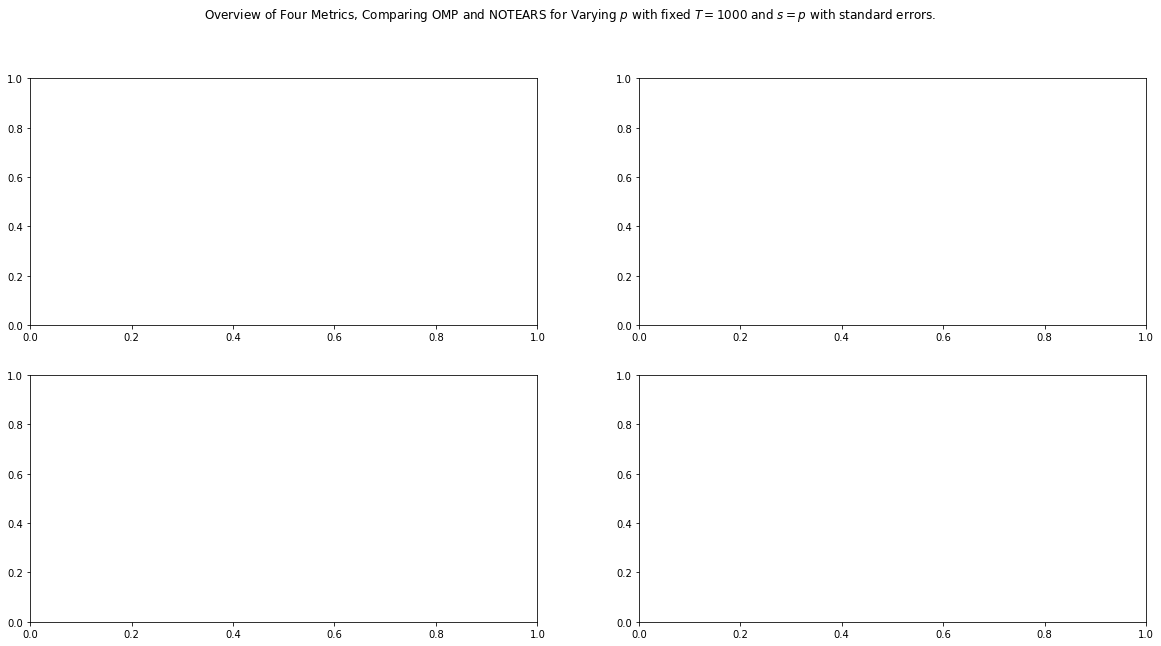

In [41]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Overview of Four Metrics, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Detection Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'Mean Squared Error (lower is better)']

for i in range(4):
    axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1), label = "OMP")
    axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1) - scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), np.mean(np.array(r_OMP)[:, i + 1], axis = 1) + scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), alpha = 0.2)

#     axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1), label = "NOTEARS")
#     axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1) - scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), np.mean(np.array(r_NT)[:, i + 1], axis = 1) + scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), alpha = 0.2)
    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')